In [10]:
import random
import numpy as np
from game import Game, Move, Player
from copy import deepcopy

border = []
for i in range(5):
    for j in range(5):
        if i == 0 or i == 4 or j == 0 or j == 4:
            border.append((i, j))
BORDER = (list(set(border)))
print(len(BORDER))

ALL_MOVES = []
for pos in BORDER:
    possible_moves = [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]
            
    if pos[0] == 0: possible_moves.remove(Move.LEFT)
    if pos[0] == 4: possible_moves.remove(Move.RIGHT)
    if pos[1] == 0: possible_moves.remove(Move.TOP)
    if pos[1] == 4: possible_moves.remove(Move.BOTTOM)

    for move in possible_moves: ALL_MOVES.append((pos, move))
N_ALL = len(ALL_MOVES)

class RandomPlayer(Player):
    def __init__(self) -> None:
        super().__init__()

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:

        from_pos = random.choice(BORDER)
        while game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx: from_pos = random.choice(BORDER)

        possible_moves = [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]
            
        if from_pos[0] == 0: possible_moves.remove(Move.LEFT)
        if from_pos[0] == 4: possible_moves.remove(Move.RIGHT)
        if from_pos[1] == 0: possible_moves.remove(Move.TOP)
        if from_pos[1] == 4: possible_moves.remove(Move.BOTTOM)
        
        move = random.choice(possible_moves)

        return from_pos, move

16


In [11]:
class ID_generator:
    def __init__(self):
        self.id = -1
    def get_id(self):
        self.id += 1
        return self.id

In [12]:
# weight definition
INPUT_SHAPE = (3, 5, 5)
WEIGHT_SHAPE = np.array([
    [
        ('dense', 64),
        ('dense', 128),
        ('dense', N_ALL),
    ],
    [
        ('conv', (3, 5, 1)),
        ('dense', 64),
        ('dense', N_ALL),
    ],
    [
        ('conv', (3, 1, 5)),
        ('dense', 64),
        ('dense', N_ALL),
    ],
    [
        ('conv', (3, 2, 2)),
        ('dense', N_ALL),
    ],
    [
        ('conv', (3, 3, 3)),
        ('conv', (3, 2, 2)),
        ('dense', N_ALL),
    ],
], dtype= object)

def multiply(x):
    res = 1
    for xx in x: res *= xx
    return res

class MyPlayer(Player):
    def __init__(self, id, heritage= None) -> None:
        super().__init__()

        self.id = id

        if heritage is None:
            self.W = []
            self.b = []

            for branch in WEIGHT_SHAPE:
                branch_w = []
                branch_b = []
                in_shape = INPUT_SHAPE

                for layer in branch:
                    #print(in_shape)
                    #print(layer)

                    if layer[0] == 'dense':
                        in_shape = multiply(in_shape)
                        branch_w.append(np.random.random(size= (in_shape, layer[1])))
                        branch_b.append(np.random.random(size= (layer[1],)))
                        in_shape = (layer[1],)

                    elif layer[0] == 'conv':

                        if len(in_shape) == 2:
                            branch_w.append(np.random.random(size= layer[1]))
                            branch_b.append(np.random.random(size= (layer[1][0],)))
                            in_shape = (layer[1][0], in_shape[0] - layer[1][1] + 1, in_shape[1] - layer[1][2] + 1)

                        else:
                            branch_w.append(np.random.random(size= (layer[1][0] * in_shape[0], layer[1][1], layer[1][2])))
                            branch_b.append(np.random.random(size= (layer[1][0] * in_shape[0],)))
                            in_shape = (layer[1][0] * in_shape[0], in_shape[1] - layer[1][1] + 1, in_shape[2] - layer[1][2] + 1)

                    else: print('error')

                    #print(branch_w[-1].shape)
                    #print(branch_b[-1].shape)
                    #print('-')

                    #print(in_shape)
                #print('-----')

                self.W.append(branch_w)
                self.b.append(branch_b)

            self.W = np.array(self.W, dtype= object)
            self.b = np.array(self.b, dtype= object)

        else:
            self.W = heritage[0]
            self.b = heritage[1]

        self.fitness = 0
        self.until_surrend = 100
        self.epoch_before_death = 3

    def get_id(self): return self.id
    def reset_fitness(self) -> None: self.fitness = 0
    def mod_fitness(self, mod) -> None: self.fitness += mod
    def get_fitness(self): return self.fitness
    def set_fitness(self, new_value) -> None: self.fitness = new_value
    def get_weights(self): return self.W
    def get_biases(self): return self.b
    def prepare_to_surrend(self, amount= 100)-> None: self.until_surrend = amount
    def get_death(self, bonus= None):
        if bonus is not None: self.epoch_before_death = bonus + 1
        self.epoch_before_death -= 1
        return self.epoch_before_death
    
    def compute_move(self, X):
        branch_outputs = []

        for i_branch in range(len(self.W)):
            layer_input = deepcopy(X)

            for i_layer in range(len(self.W[i_branch])):
                layer_info = WEIGHT_SHAPE[i_branch][i_layer]

                if layer_info[0] == 'dense':
                    layer_output = np.dot(layer_input.flatten(), self.W[i_branch][i_layer]) + self.b[i_branch][i_layer]
                
                elif layer_info[0] == 'conv':

                    if len(layer_input.shape) == 2:
                        layer_output = np.zeros((layer_info[1][0], layer_input.shape[0] - layer_info[1][1] + 1, layer_input.shape[1] - layer_info[1][2] + 1))
                        for k in range(layer_output.shape[0]):
                            for i in range(layer_output.shape[1]):
                                for j in range(layer_output.shape[2]):
                                    layer_output[k, i, j] = sum(sum(layer_input[i:i+layer_info[1][1], j:j+layer_info[1][2]] * self.W[i_branch][i_layer][k]))
                    
                    else:
                        layer_output = np.zeros((layer_info[1][0] * layer_input.shape[0], layer_input.shape[1] - layer_info[1][1] + 1, layer_input.shape[2] - layer_info[1][2] + 1))
                        for k_in in range(layer_input.shape[0]):
                            for k in range(layer_info[1][0]):
                                for i in range(layer_output.shape[1]):
                                    for j in range(layer_output.shape[2]):
                                        layer_output[k_in*layer_info[1][0]+k, i, j] = sum(sum(layer_input[k_in, i:i+layer_info[1][1], j:j+layer_info[1][2]] * self.W[i_branch][i_layer][k_in*layer_info[1][0]+k]))
                
                else: print('error')

                layer_input = layer_output
                #print(f'{(i_branch, i_layer)} -> {layer_output.shape}')
            
            branch_outputs.append(layer_output)

        output = np.sum(branch_outputs, axis= 0)
        output = np.argmax(output)
        
        return output


    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:

        self.until_surrend -= 1
        if self.until_surrend == 0:
            #print('surrendering')
            self.fitness -= 100
            return (-1, -1), None
        
        ## provare a generare tre mappe dalla board, una per ogni [-1, 0, 1] con 1 se [-1, 0, 1] in tile e 0 se altre
        #--------------------------------------

        board = game.get_board()
        X = np.zeros((3, board.shape[0], board.shape[1]))
        X[0][board == -1] = 1
        X[1][board == 0] = 1
        X[2][board == 1] = 1

        ######################################
        
        # invert the board based on player_turn to better recognize enemies from allies
        #--------------------------------------
        
        if game.current_player_idx == 1: pass
        else:
            tmp = deepcopy(X[1])
            X[1] = deepcopy(X[2])
            X[2] = tmp

        #######################################

        # compute move
        #--------------------------------------

        from_pos, move = ALL_MOVES[self.compute_move(X)]

        #######################################

        # random move if illegal move chosen with penalty
        #--------------------------------------

        if game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx:

            #print('random used - penalty')
            self.fitness -= 50

            from_pos = random.choice(BORDER)
            while game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx: from_pos = random.choice(BORDER)

            possible_moves = [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]
                
            if from_pos[0] == 0: possible_moves.remove(Move.LEFT)
            if from_pos[0] == 4: possible_moves.remove(Move.RIGHT)
            if from_pos[1] == 0: possible_moves.remove(Move.TOP)
            if from_pos[1] == 4: possible_moves.remove(Move.BOTTOM)
            
            move = random.choice(possible_moves)

        #######################################
            
        # removing 1 to fitness for each move to force active play
        #--------------------------------------
        
        self.fitness -= 1

        #######################################
        
        return from_pos, move

In [13]:
id_gen = ID_generator()
player = MyPlayer(id_gen.get_id())
game = Game()
player.make_move(game)

((3, 4), <Move.LEFT: 2>)

In [14]:
N_TRIALS = 10

## maybe N_TRIALS should depend on N_ALL

def evaluate_population(population, fs= None, avg_player = None):

    for p in population:
        
        p.reset_fitness()

        for _ in range(N_TRIALS):

            if fs is None or fs == 'onlyfirst':
                p.prepare_to_surrend()
                p.mod_fitness(((1 - Game().play(p, RandomPlayer())) * 2 - 1) * 100)

            if fs is None or fs == 'onlysecond':
                p.prepare_to_surrend()
                p.mod_fitness((Game().play(RandomPlayer(), p) * 2 - 1) * 100)

    if avg_player is not None: evaluate_population_2(population, avg_player, fs= fs)

def evaluate_population_2(population, avg_player, fs= None):

    freeze_fitness = avg_player.get_fitness()

    for p in population:

        for _ in range(1):

            if fs is None or fs == 'first':
                p.prepare_to_surrend()
                avg_player.prepare_to_surrend()
                winner = Game().play(p, avg_player)
                p.mod_fitness(((1 - winner) * 2 - 1) * 100)

            if fs is None or fs == 'second':
                p.prepare_to_surrend()
                avg_player.prepare_to_surrend()
                winner = Game().play(avg_player, p)
                p.mod_fitness((winner * 2 - 1) * 100)
    
    avg_player.set_fitness(freeze_fitness)
            

In [15]:
def procreate_1(p1, p2, c1, c2, id):
    
    W1 = p1.get_weights()
    b1 = p1.get_biases()
    W2 = p2.get_weights()
    b2 = p2.get_biases()

    W3 = deepcopy(W1)
    b3 = deepcopy(b1)

    c = c1 / (c1 + c2)

    for i in range(len(W1)):
        for j in range(len(W1[i])):
            if c < np.random.random():
                W3[i][j] = W2[i][j]
                b3[i][j] = b2[i][j]

    return MyPlayer(id, heritage= (W3, b3))

def procreate_2(p1, p2, c1, c2, id):
    
    W1 = p1.get_weights()
    b1 = p1.get_biases()
    W2 = p2.get_weights()
    b2 = p2.get_biases()

    W3 = deepcopy(W1)
    b3 = deepcopy(b1)

    c = c1 / (c1 + c2)

    for i in range(len(W1)):
        if c < np.random.random():
            W3[i] = W2[i]
            b3[i] = b2[i]

    return MyPlayer(id, heritage= (W3, b3))

def softmax_temp(x, t= 1):
    e_x = np.exp(x / t)
    return e_x / sum(e_x)

def procreation(population, id_generator):
        
    mod_scores = softmax_temp(np.array([p.get_fitness() for p in population]), 1000)
    
    parents = []
    for _ in range(15):
        parents.append(np.random.choice([i for i in range(len(population))], size= (2,), replace= False, p= mod_scores))

    childrens = []
    for pair in parents:
        pi = population[pair[0]]
        pj = population[pair[1]]
        mod_i = mod_scores[pair[0]]
        mod_j = mod_scores[pair[1]]
        
        rand = np.random.random()
        if 0.5 >= rand:
            childrens.append(procreate_1(pi, pj, mod_i, mod_j, id_generator.get_id()))
        else:
            childrens.append(procreate_2(pi, pj, mod_i, mod_j, id_generator.get_id()))

    return childrens

In [16]:
P_MUTATION = 0.1
MUTATION_STRENGTH = 0.1

def mutate_1(p, id):

    Wm = deepcopy(p.get_weights())
    bm = deepcopy(p.get_biases())

    for i in range(len(Wm)):
        for j in range(len(Wm[i])):

            for ii in range(Wm[i][j].shape[0]):
                for jj in range(Wm[i][j].shape[1]):
                    if P_MUTATION >= np.random.random():
                        Wm[i][j][ii, jj] += np.random.normal(0, MUTATION_STRENGTH, size= Wm[i][j][ii, jj].shape)

            for ii in range(bm[i][j].shape[0]):
                if P_MUTATION >= np.random.random():
                    bm[i][j][ii] += np.random.normal(0, MUTATION_STRENGTH, size= bm[i][j][ii].shape)

    return MyPlayer(id, heritage= (Wm, bm))

def mutate_2(p, id):

    Wm = deepcopy(p.get_weights())
    bm = deepcopy(p.get_biases())

    for i in range(len(Wm)):
        for j in range(len(Wm[i])):
            if P_MUTATION >= np.random.random():
                Wm[i][j] += np.random.normal(0, MUTATION_STRENGTH, size= Wm[i][j].shape)
            if P_MUTATION >= np.random.random():
                bm[i][j] += np.random.normal(0, MUTATION_STRENGTH, size= bm[i][j].shape)

    return MyPlayer(id, heritage= (Wm, bm))

def mutation(population, id_generator):

    bases = np.random.choice([i for i in range(len(population))], size= (15,), replace= False)

    mutants = []
    for base in bases:
        p = population[base]
        rand = np.random.random()
        if 0.5 >= rand:
            mutants.append(mutate_1(p, id_generator.get_id()))
        else:
            mutants.append(mutate_2(p, id_generator.get_id()))

    return mutants

In [17]:
MAX_EPOCH = 100
MAX_POPULATION = 100

id_generator = ID_generator()

population = [MyPlayer(id_generator.get_id()) for _ in range(MAX_POPULATION)]

ids = []
ps = []
tot_scores = []
times = []

for epoch in range(MAX_EPOCH):

    print(f'------------------------------------\nepoch {epoch}')

    evaluate_population(population)
    #evaluate_population(population, avg_player= population[len(population) // 2])
    scores = np.array([p.get_fitness() for p in population])

    idx_sort = np.argsort(scores)[::-1]
    scores = scores[idx_sort]
    population = [population[i] for i in idx_sort]

    print(scores[:10])
    print([p.get_id() for p in population[:10]])

    # compute avg ranking
    #--------------------------------------

    for p, s in zip(population, scores):
        p_id = p.get_id()

        if p_id in ids:
            idx = np.argwhere(np.array(ids) == p_id)[0][0]
            tot_scores[idx] += s
            times[idx] += 1

        else:
            ids.append(p_id)
            ps.append(p)
            tot_scores.append(s)
            times.append(1)

    #######################################

    # provare ad implementare morte dopo tot che non si è tra i primi tot
    #--------------------------------------

    to_death = []
    for i, p in enumerate(population):
        bonus_epochs = 4 if i < MAX_POPULATION / 2 else None
        if p.get_death(bonus_epochs) == 0: to_death.append(p)
    for p in to_death: population.remove(p)

    #######################################

    ## magari aumentare e diminuire aumento popolazione in base a grandezza popolazione

    print(f'before: {len(population)}')

    ## procreazione (probabilita dipendente da fitness)

    childrens = procreation(population, id_generator)
    print(f'n_childrens: {len(childrens)}')

    ## mutazioni (tante ma random su individui random)

    mutants = mutation(population, id_generator)
    print(f'n_mutants: {len(mutants)}')

    for child in childrens: population.append(child)
    for mutant in mutants: population.append(mutant)

    print(f'after: {len(population)}')

    #

------------------------------------
epoch 0
[  787   496   265    36  -107  -208  -899 -1078 -1094 -1544]
[82, 37, 18, 87, 89, 58, 68, 53, 48, 14]
before: 100
n_childrens: 15
n_mutants: 15
after: 130
------------------------------------
epoch 1
[1767 1515 1452 1198  997  838  631  295  229  182]
[87, 128, 106, 42, 113, 112, 48, 89, 107, 103]
before: 130
n_childrens: 15
n_mutants: 15
after: 160
------------------------------------
epoch 2
[1866 1620 1423 1367  851  798  735  726  694  638]
[103, 135, 68, 114, 150, 113, 110, 139, 109, 138]
before: 112
n_childrens: 15
n_mutants: 15
after: 142
------------------------------------
epoch 3
[1839 1506 1480 1446 1398 1252 1205  892  791  751]
[113, 37, 177, 18, 114, 168, 82, 167, 103, 118]
before: 132
n_childrens: 15
n_mutants: 15
after: 162
------------------------------------
epoch 4
[1872 1669 1262 1229 1199 1158 1067 1043  951  946]
[18, 194, 200, 165, 204, 170, 42, 143, 104, 172]
before: 130
n_childrens: 15
n_mutants: 15
after: 160
-----

KeyboardInterrupt: 

2677
[2762, 2764, 2740, 2761, 2742, 2725, 2748, 2728, 2757, 2608]
[1, 1, 1, 1, 1, 2, 1, 2, 1, 6]
[1593.         1210.         1193.         1056.         1037.
 1001.5         914.          901.5         891.          884.66666667]


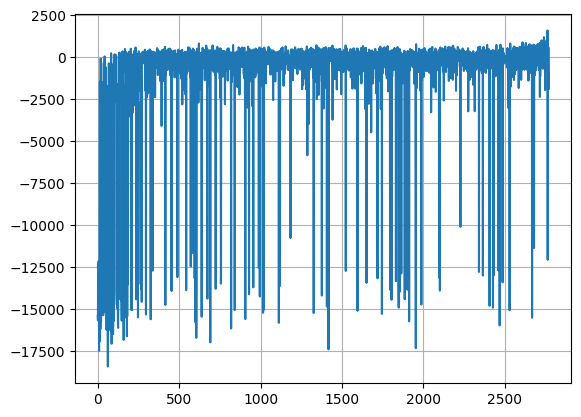

In [18]:
avg_scores = np.array(tot_scores) / np.array(times)

idx_sort = np.argsort(avg_scores)[::-1]

ids = [ids[i] for i in idx_sort]
ps = [ps[i] for i in idx_sort]
tot_scores = [tot_scores[i] for i in idx_sort]
times = [times[i] for i in idx_sort]
avg_scores = avg_scores[idx_sort]

print(population[0].get_id())
print(ids[:10])
print(times[:10])
print(avg_scores[:10])

idx_sort = np.argsort(ids)[::-1]

ids = [ids[i] for i in idx_sort]
ps = [ps[i] for i in idx_sort]
tot_scores = [tot_scores[i] for i in idx_sort]
times = [times[i] for i in idx_sort]
avg_scores = avg_scores[idx_sort]

import matplotlib.pyplot as plt

x = ids
y = avg_scores
plt.plot(x, y)
plt.grid()
plt.show()



In [19]:
#ThePlayer = population[0]
ThePlayer = ps[0]

In [20]:
wins_first = 0
wins_second = 0
n_trials = 1000

player1 = ThePlayer
player2 = RandomPlayer()

for _ in range(n_trials):
    g = Game()

    player1.prepare_to_surrend(500)
    winner = g.play(player1, player2)

    if winner == 0: wins_first += 1

    g = Game()

    player1.prepare_to_surrend(500)
    winner = g.play(player2, player1)

    if winner == 1: wins_second += 1

print(f"Player won {wins_first} / {n_trials} as first")
print(f"Player won {wins_second} / {n_trials} as second")

Player won 910 / 1000 as first
Player won 885 / 1000 as second
